In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import os
import pathlib

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

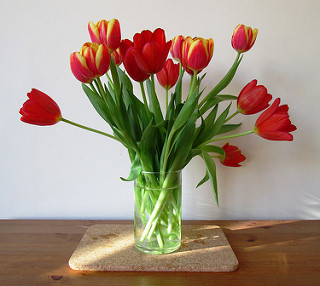

In [4]:
imagen = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(imagen[0]))

In [29]:
batch_size = 32
img_height = 180
img_width = 180

In [30]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% para validación, 80% para entrenamiento
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

data_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% para validación, 80% para entrenamiento
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [31]:
data_train.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
data_train = data_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
data_val = data_val.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
num_clases = 5  # Porque al traer las imágenes nos retornó 5 clases

modelo = tf.keras.models.Sequential([
    # Capas convolucionales
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_clases)
])

In [35]:
modelo.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [36]:
modelo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [37]:
epoch = 10
historial = modelo.fit(data_train,
                       validation_data=data_val,
                       epochs=epoch)

Epoch 1/10
92/92 [==============================] - 3s 21ms/step - loss: 1.2963 - accuracy: 0.4629 - val_loss: 1.0220 - val_accuracy: 0.5831
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 0.9303 - accuracy: 0.6441 - val_loss: 0.9818 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.7390 - accuracy: 0.7173 - val_loss: 0.9895 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 2s 18ms/step - loss: 0.4923 - accuracy: 0.8188 - val_loss: 1.0184 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2690 - accuracy: 0.9104 - val_loss: 1.2351 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1499 - accuracy: 0.9561 - val_loss: 1.3753 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.0946 - accuracy: 0.9748 - val_loss: 1.4773 - val_accuracy: 0.5995
Epoch 8/10
92

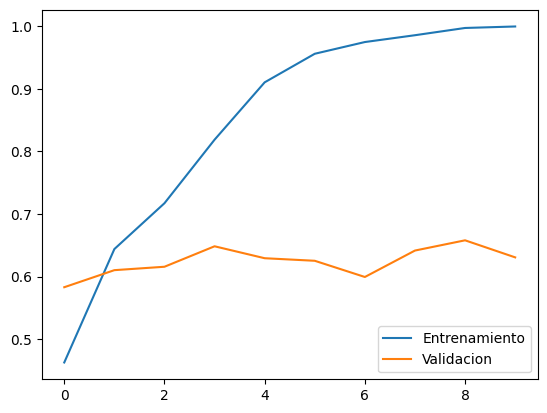

In [38]:
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']
loss = historial.history['loss']
val_loss = historial.history['val_loss']

plt.plot(range(epoch), acc, label='Entrenamiento')
plt.plot(range(epoch), val_acc, label='Validacion')
plt.legend(loc='lower right')

Vemos que en el entrenamiento estamos obteniendo resultados casi perfectos, pero
en la validación estamos obteniendo resultados muchos menores.

Esto es un claro ejemplo de que el modelo está haciendo overfitting.

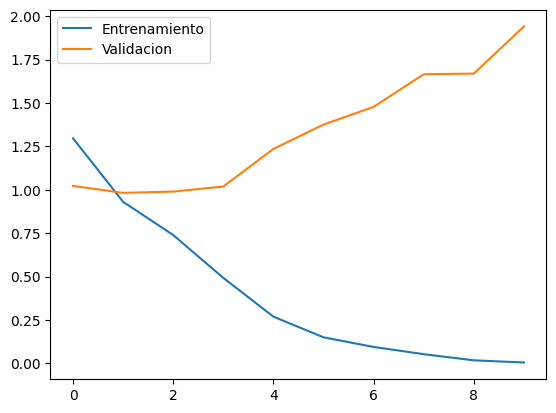

In [43]:
plt.plot(range(epoch), loss, label='Entrenamiento')
plt.plot(range(epoch), val_loss, label='Validacion')
plt.legend(loc='upper left')

Lo mismo sucede en cuanto a la pérdida. En el entrenamiento, el valor de pérdida
se reduce conforme pasa el tiempo, pero en la validación primero se reduce un
poco para luego crecer.

Esto nos demuestra que, claramente, el modelo está sufriendo overfitting.

Para solucionar el overfitting, se tienen muchas soluciones.

En este caso, utilizaremos el **Incremento de data**, que consiste en crear
múltiples imágenes a partir de una misma imagen.

In [45]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

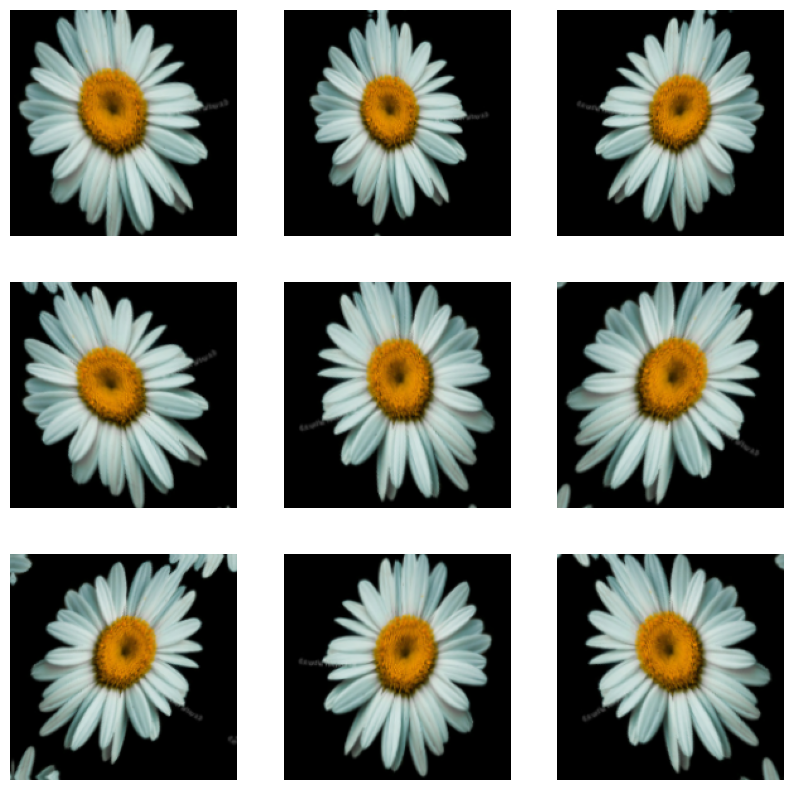

In [46]:
plt.figure(figsize=(10, 10))

for images, _ in data_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [47]:
nuevo_modelo = tf.keras.models.Sequential([
    data_augmentation,
    modelo
])

In [48]:
nuevo_modelo.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [49]:
epoch = 10
historial = nuevo_modelo.fit(data_train,
                             validation_data=data_val,
                             epochs=epoch)

Epoch 1/10
92/92 [==============================] - 8s 72ms/step - loss: 0.8829 - accuracy: 0.7054 - val_loss: 0.8452 - val_accuracy: 0.7003
Epoch 2/10
92/92 [==============================] - 6s 69ms/step - loss: 0.6539 - accuracy: 0.7585 - val_loss: 0.8700 - val_accuracy: 0.6608
Epoch 3/10
92/92 [==============================] - 6s 69ms/step - loss: 0.6151 - accuracy: 0.7718 - val_loss: 0.7469 - val_accuracy: 0.7112
Epoch 4/10
92/92 [==============================] - 6s 70ms/step - loss: 0.5862 - accuracy: 0.7813 - val_loss: 0.7434 - val_accuracy: 0.7098
Epoch 5/10
92/92 [==============================] - 7s 71ms/step - loss: 0.5406 - accuracy: 0.8004 - val_loss: 0.8448 - val_accuracy: 0.7030
Epoch 6/10
92/92 [==============================] - 7s 76ms/step - loss: 0.5309 - accuracy: 0.8076 - val_loss: 0.7636 - val_accuracy: 0.7248
Epoch 7/10
92/92 [==============================] - 7s 77ms/step - loss: 0.4573 - accuracy: 0.8358 - val_loss: 0.8349 - val_accuracy: 0.7371
Epoch 8/10
92

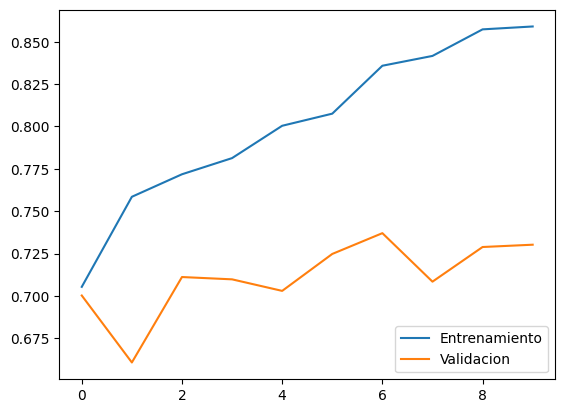

In [50]:
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']
loss = historial.history['loss']
val_loss = historial.history['val_loss']

plt.plot(range(epoch), acc, label='Entrenamiento')
plt.plot(range(epoch), val_acc, label='Validacion')
plt.legend(loc='lower right')

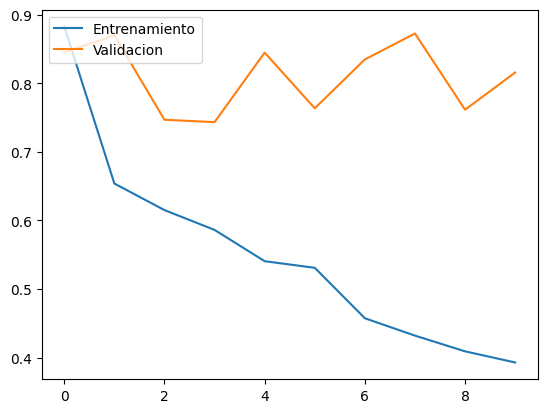

In [51]:
plt.plot(range(epoch), loss, label='Entrenamiento')
plt.plot(range(epoch), val_loss, label='Validacion')
plt.legend(loc='upper left')

In [ ]:
url = ''
path = tf.keras.utils.get_file('nombre', url)

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [ ]:
predictions = modelo.predict(img_array)
score = tf.nn.softmax(predictions[0])